In [1]:
import gc
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from typing import Tuple, List
from IPython.display import clear_output

import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data

from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

In [2]:
class Config:
    BATCH_SIZE = 256
    LEARNING_RATE = 1e-3
    NUM_EPOCHS = 60
    EARLY_STOPPING_EPOCHS = 25
    SCHEDULER_STEP_SIZE = 20
    SEED = 0 

def clear_cache():
    gc.collect()
    with torch.no_grad():
        torch.cuda.empty_cache()

def init_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: {}".format(device))

# init_seed(Config.SEED)

device: cuda


In [3]:
train_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.RandomHorizontalFlip(),
    ])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Config.BATCH_SIZE,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=Config.BATCH_SIZE,
                                         shuffle=False, num_workers=1)

classes = testset.classes
setattr(Config, "NUM_CLASSES", len(classes))

Files already downloaded and verified
Files already downloaded and verified


In [4]:
(c, w, h) = trainset[0][0].shape
print("in_channels={}\nwidth={}\nheight={}".format(*(c, w, h)))

in_channels=3
width=32
height=32


In [5]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int):
        super(ResidualBlock, self).__init__()

        self.base_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=out_channels),
            )
        
        self.downsample_block = nn.Sequential()
        if in_channels != out_channels:
            self.downsample_block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False),
                nn.BatchNorm2d(num_features=out_channels)          
            )

        self.activation = nn.ReLU()
    
    def forward(self, x):
        output = self.base_block(x) 
        output += self.downsample_block(x)
        output = self.activation(output)
        return output
    

class ResNet18(nn.Module):
    def __init__(self, num_classes: int = Config.NUM_CLASSES, conv_size: int = 7):
        super(ResNet18, self).__init__()

        if conv_size == 7:
            self.conv1 = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False),
                nn.BatchNorm2d(num_features=64),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                )
        elif conv_size == 3:
            self.conv1  = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(num_features=64),
                nn.ReLU(),
                )  
        else:
            raise NotImplementedError
        
        self.conv2_x = self._get_blocks_pair(64,  64,  1)
        self.conv3_x = self._get_blocks_pair(64,  128, 2)
        self.conv4_x = self._get_blocks_pair(128, 256, 2)
        self.conv5_x = self._get_blocks_pair(256, 512, 2)

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        self.fc = nn.Linear(512, num_classes)

    @staticmethod
    def _get_blocks_pair(in_channels: int, out_channels: int, stride: int):
        block = nn.Sequential(
            ResidualBlock(in_channels, out_channels, stride=stride),
            ResidualBlock(out_channels, out_channels, stride=1)
        )
        return block

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [6]:
class EarlyStopping:
    """
    Класс, реализующий функционал прекращения процесса обучения
    и функционал сохранения результата лучшей эпохи
    """
    def __init__(self, tolerance: int = 5, mode: str = "min", monitor: str = "loss", model_path: str = None):
         self.tolerance = tolerance
         self.mode = mode
         self.monitor = monitor
         self.best_value = np.inf if mode == "min" else -np.inf 
         self.num_non_best_epochs = 0
         self.stop_flag = False
         self.model_path = model_path
         if model_path is not None and not os.path.exists(os.path.dirname(model_path)):
             os.makedirs(os.path.dirname(model_path))

    def __call__(self, monitor_values: dict, model: nn.Module) -> None:
        if self.monitor in monitor_values:
            current_value = monitor_values.get(self.monitor)
        else:
            raise ValueError(f"Value `{self.monitor}` not presented")

        if self.mode == "min":
            condition = (current_value < self.best_value) 
        elif self.mode == "max":
            condition = (current_value > self.best_value) 
        else:
            raise ValueError(f"Unknown mode `{self.mode}`")
        
        if condition:
            self.best_value = current_value
            self.num_non_best_epochs = 0
            if self.model_path is not None:
                torch.save(model.state_dict(), self.model_path)
        else:
            self.num_non_best_epochs += 1
        if self.num_non_best_epochs > self.tolerance:
            print(f"Early stopping! Best value for {self.monitor}: {self.best_value}")
            self.stop_flag = True

In [7]:
def plot_history(train_loss_history, train_accuracy_history, 
                 test_loss_history, test_accuracy_history):
    
    fig, axs = plt.subplots(2, 2, figsize=[16, 9])
    axs[0, 0].set_title("Train loss")
    axs[0, 0].plot(train_loss_history)
    axs[0, 0].grid()

    axs[0, 1].set_title("Train accuracy")
    axs[0, 1].plot(train_accuracy_history)
    axs[0, 1].grid()

    axs[1, 0].set_title("Test loss")
    axs[1, 0].plot(test_loss_history)
    axs[1, 0].grid()

    axs[1, 1].set_title("Test accuracy")
    axs[1, 1].plot(test_accuracy_history)
    axs[1, 1].grid()

    plt.show()


def train(
        net: nn.Module, 
        trainloader: torch.utils.data.DataLoader,
        optimizer: torch.optim.Optimizer, 
        criterion: torch.nn.modules.loss._Loss, 
        **kwargs
        ) -> Tuple[float, float]:
    """Метод, реализующий одну эпоху обучения модели"""
    net.train()
    train_loss, train_accuracy = 0.0, 0.0
    with tqdm(trainloader, unit="train") as tbatches:
        for x_batch, y_batch in tbatches:
            tbatches.set_description(f"[Train] Epoch {kwargs.get('epoch', 0)}")

            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            output = net(x_batch)
            loss = criterion(output, y_batch)

            preds = output.argmax(dim=1, keepdim=True).squeeze()
            correct = (preds == y_batch).sum().item()
            accuracy = correct / len(x_batch)

            train_accuracy += accuracy
            train_loss += loss.data.cpu().item()

            loss.backward()
            optimizer.step()

            tbatches.set_postfix(loss=loss.data.item(), accuracy=accuracy)
    return  train_loss, train_accuracy


@torch.no_grad()
def eval(
        net: nn.Module, 
        testloader: torch.utils.data.DataLoader,
        criterion: torch.nn.modules.loss._Loss, 
        **kwargs
        ) -> Tuple[float, float]:
    """Метод, реализующий инференс модели"""
    net.eval()
    test_loss, test_accuracy = 0.0, 0.0
    with tqdm(testloader, unit="test") as tbatches:
        for x_batch, y_batch in tbatches:
            tbatches.set_description(f"[Eval] Epoch {kwargs.get('epoch', 0)}")

            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            output = net(x_batch)
            loss = criterion(output, y_batch)

            preds = output.argmax(dim=1, keepdim=True).squeeze()
            correct = (preds == y_batch).sum().item()
            accuracy = correct / len(x_batch)

            test_accuracy += accuracy
            test_loss += loss.data.cpu().item()

            tbatches.set_postfix(loss=loss.data.item(), accuracy=accuracy)
    return  test_loss, test_accuracy
        

def train_eval_loop(
        net: nn.Module, 
        trainloader: torch.utils.data.DataLoader,
        testloader: torch.utils.data.DataLoader,
        optimizer: torch.optim.Optimizer = None, 
        criterion: torch.nn.modules.loss._Loss = None, 
        scheduler: torch.optim.lr_scheduler.LRScheduler = None,
        early_stopping: EarlyStopping = None,
        **kwargs
        ) -> None:
    """Метод, реализующий цикл обучения и валидации модели"""
    train_loss_history, test_loss_history = [], []
    train_accuracy_history, test_accuracy_history = [], []

    if optimizer is None:
        optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    if criterion is None:
        criterion = nn.CrossEntropyLoss()

    for epoch in range(0, kwargs.get("n_epochs", 10) + 1):

        # training stage
        train_loss, train_accuracy = train(net, trainloader, optimizer, criterion, epoch=epoch)
        train_loss_history.append(train_loss / len(trainloader))
        train_accuracy_history.append(train_accuracy / len(trainloader))
        if scheduler is not None:
            scheduler.step(train_loss / len(trainloader))

        # evaluation stage
        test_loss, test_accuracy = eval(net, testloader, criterion, epoch=epoch)
        test_loss_history.append(test_loss / len(testloader))
        test_accuracy_history.append(test_accuracy / len(testloader))

        clear_output(True)
        plot_history(train_loss_history, train_accuracy_history, 
                    test_loss_history, test_accuracy_history)
    
        # early stopping and saving best model
        if early_stopping is not None:
            monitor_values = {
                "loss": test_loss / len(testloader),
                "accuracy": test_accuracy / len(testloader)
                }   
            early_stopping(monitor_values, net)
            if early_stopping.stop_flag:
                break
            
    print("Training finished!")

## Обучение и валидация 

#### Сеть с первым слоем со свёрткой 7 на 7 и MaxPooling

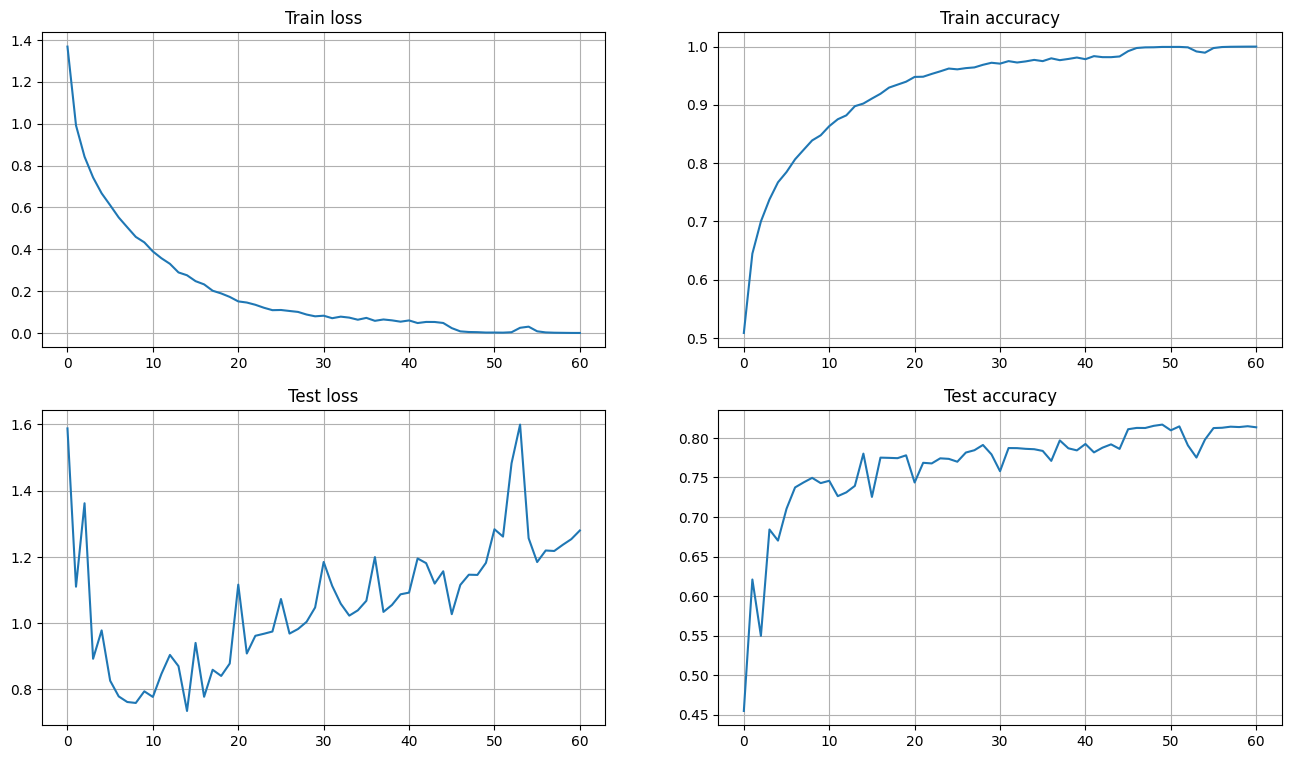

Training finished!


In [9]:
net = None
clear_cache() 

net = ResNet18(conv_size=7).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=Config.LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-5) 
early_stopping = EarlyStopping(Config.EARLY_STOPPING_EPOCHS, mode="max", monitor="accuracy",
                               model_path="./checkpoint/model7x7_best.pt")

train_eval_loop(
    net=net, 
    trainloader=trainloader, 
    testloader=testloader, 
    optimizer=optimizer, 
    criterion=criterion, 
    scheduler=scheduler, 
    early_stopping=early_stopping, 
    n_epochs=Config.NUM_EPOCHS
    )

#### Сеть с первым слоем со свёрткой 3 на 3 и без MaxPooling

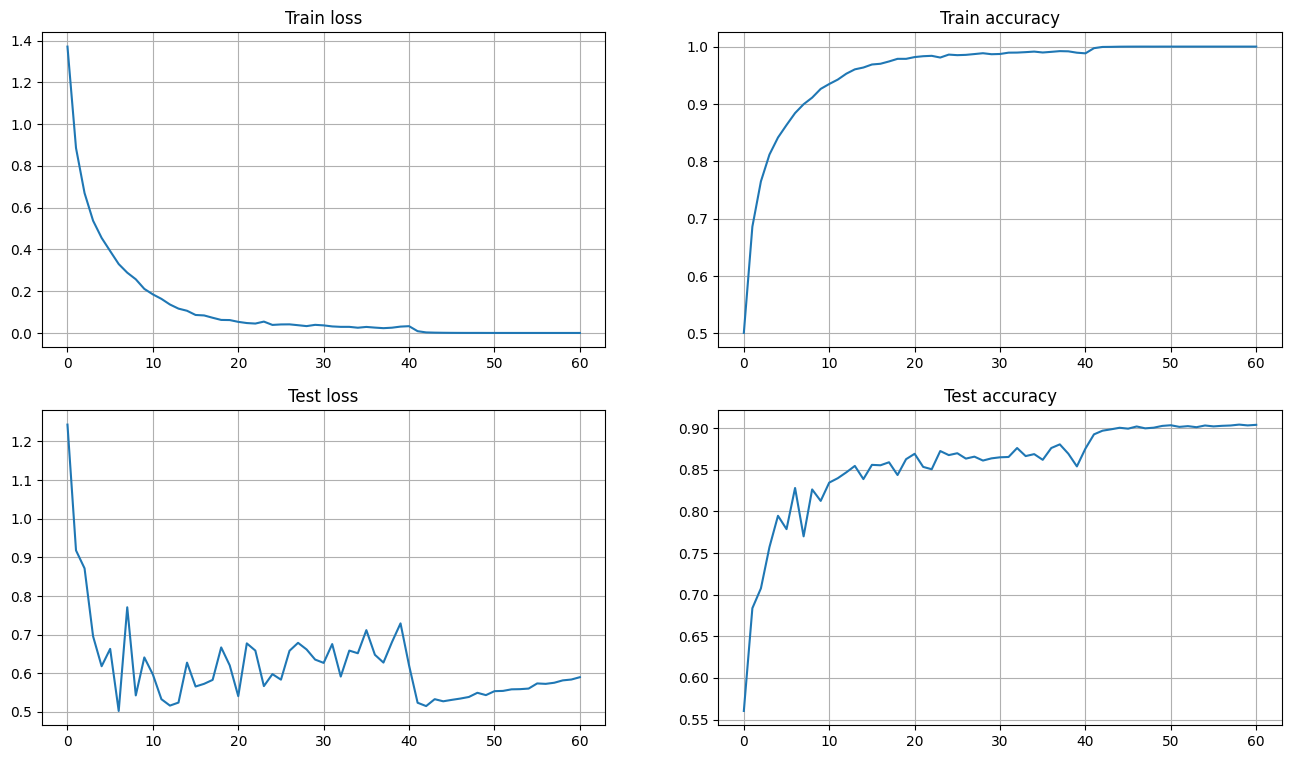

Training finished!


In [11]:
net = None
clear_cache()

net = ResNet18(conv_size=3).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=Config.LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-5)
early_stopping = EarlyStopping(Config.EARLY_STOPPING_EPOCHS, mode="max",  monitor="accuracy",
                               model_path="./checkpoint/model3x3_best.pt")

train_eval_loop(
    net=net, 
    trainloader=trainloader, 
    testloader=testloader, 
    optimizer=optimizer, 
    criterion=criterion, 
    scheduler=scheduler, 
    early_stopping=early_stopping, 
    n_epochs=Config.NUM_EPOCHS
    )

## Результаты

In [12]:
@torch.no_grad()
def predict(net: nn.Module) -> Tuple[np.ndarray, np.ndarray]:
    """Метод, реализующий инференс модели с предсказанием вероятностей и классов"""
    net.eval()
    test_accuracy = 0.0
    preds_list, labels_list = [], []
    with tqdm(testloader, unit="test") as tbatches:
        for x_batch, y_batch in tbatches:
            tbatches.set_description(f"[Predict]")

            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            output = net(x_batch)
            
            preds = output.argmax(dim=1, keepdim=True).squeeze()
            correct = (preds == y_batch).sum().item()
            accuracy = correct / len(x_batch)

            test_accuracy += accuracy

            preds_list.append(torch.softmax(output, 1).cpu().numpy())
            labels_list.extend(list(y_batch.cpu().numpy()))
    print(f"Accuracy: {test_accuracy / len(testloader):.03f}")

    y_true = np.zeros((len(labels_list), Config.NUM_CLASSES))
    for i, label in enumerate(labels_list):
        y_true[i, label] = 1

    return np.vstack(preds_list), y_true

In [13]:
net = None
clear_cache()

net = ResNet18(conv_size=7).to(device)
net.load_state_dict(torch.load("./checkpoint/model7x7_best.pt"))

y_pred7x7, y_true7x7 = predict(net)

[Predict]: 100%|██████████| 40/40 [00:02<00:00, 16.53test/s]

Accuracy: 0.817


In [14]:
net = None
clear_cache()

net = ResNet18(conv_size=3).to(device)
net.load_state_dict(torch.load("./checkpoint/model3x3_best.pt"))

y_pred3x3, y_true3x3 = predict(net)

[Predict]: 100%|██████████| 40/40 [00:03<00:00, 11.78test/s]

Accuracy: 0.904


## ROC curves

В данном случае существует несколько способов построить ROC-кривую интегрального качества классификации по всем классам:
- Можно усреднить кривые, полученные отдельно для каждого класса (Macro Average)
- Можно построить кривую, используя предсказания сразу для всех классов (Micro Average)

Далее будут приведены оба варианта 

### Micro-averaged ROC curve

Использование предсказаний сразу для всех классов 

In [15]:
import sklearn.metrics as metrics

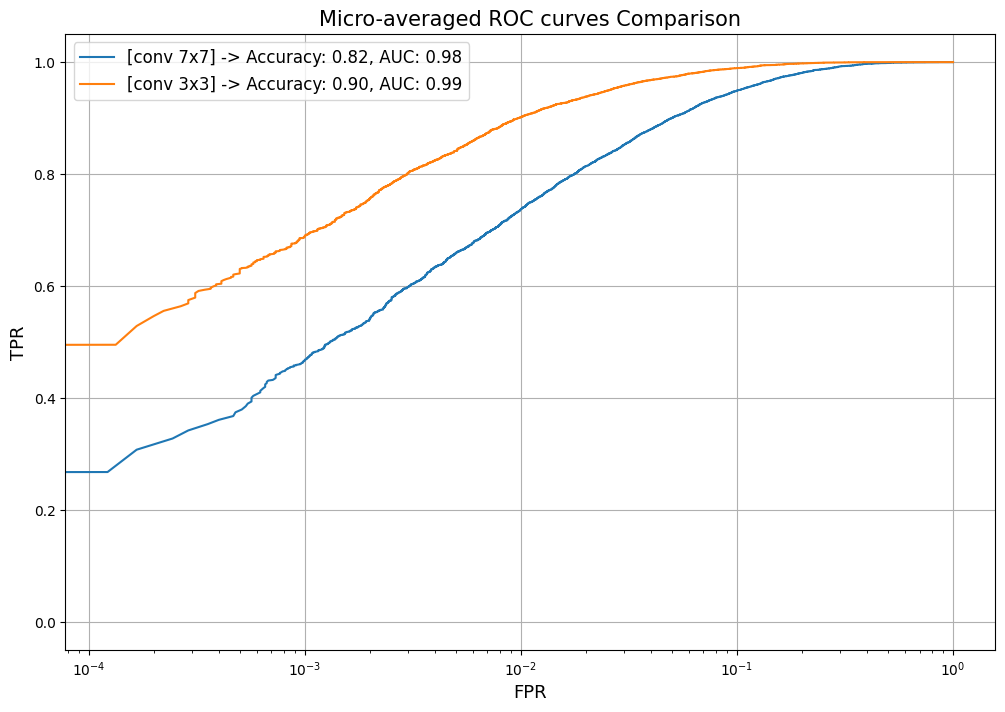

In [16]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))

def micro_averaged_roc_curve(y_true: np.ndarray, y_pred: np.ndarray):
    fpr, tpr, _ = metrics.roc_curve(y_true.ravel(), y_pred.ravel())
    return fpr, tpr

def accuracy(y_true: np.ndarray, y_pred: np.ndarray):
    return np.mean(np.argmax(y_true, 1) == np.argmax(y_pred, 1))

fpr7x7, tpr7x7 = micro_averaged_roc_curve(y_true7x7, y_pred7x7)
axs.plot(
    *(fpr7x7, tpr7x7),
    label=f"[conv 7x7] -> Accuracy: {accuracy(y_true7x7, y_pred7x7):.2f}, AUC: {metrics.auc(fpr7x7, tpr7x7):.2f}",
    color="#1f77b4"
)

fpr3x3, tpr3x3 = micro_averaged_roc_curve(y_true3x3, y_pred3x3)
axs.plot(
    *(fpr3x3, tpr3x3),
    label=f"[conv 3x3] -> Accuracy: {accuracy(y_true3x3, y_pred3x3):.2f}, AUC: {metrics.auc(fpr3x3, tpr3x3):.2f}",
    color="#ff7f0e"
)

axs.set_xlabel("FPR", fontsize=13)
axs.set_ylabel("TPR", fontsize=13)
axs.set_xscale("log")
axs.set_title("Micro-averaged ROC curves Comparison", fontsize=15)
axs.legend(loc="upper left", fontsize=12)
axs.grid()
plt.show()

### Macro-averaged ROC curve

Усреднение предсказаний, полученных отдельно для каждого из классов

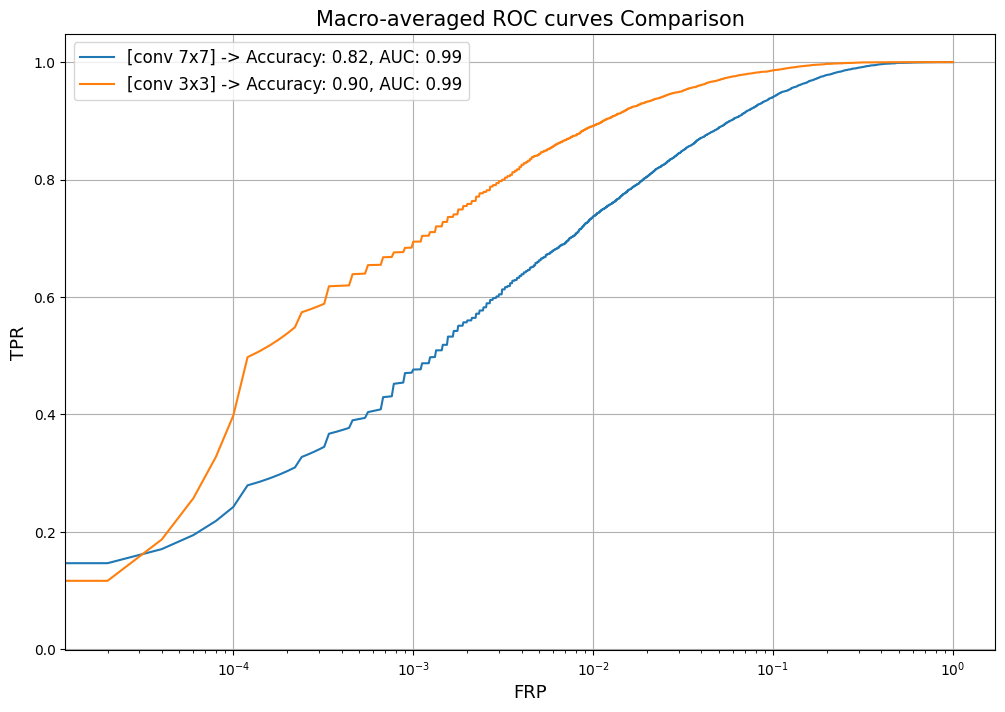

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))

def macro_averaged_roc_curve(y_true: np.ndarray, y_pred: np.ndarray):
    fpr_avg = np.linspace(0.0, 1.0, 50000)
    tpr_avg = np.zeros_like(fpr_avg)
    for i in range(Config.NUM_CLASSES):
        fpr, tpr, _ = metrics.roc_curve(y_true[:, i], y_pred[:, i])
        tpr_avg += np.interp(fpr_avg, fpr, tpr)
    tpr_avg /= Config.NUM_CLASSES
    return fpr_avg, tpr_avg

fpr7x7, tpr7x7 = macro_averaged_roc_curve(y_true7x7, y_pred7x7)
axs.plot(
    *(fpr7x7, tpr7x7),
    label=f"[conv 7x7] -> Accuracy: {accuracy(y_true7x7, y_pred7x7):.2f}, AUC: {metrics.auc(fpr3x3, tpr3x3):.2f}",
    color="#1f77b4"
)

fpr3x3, tpr3x3 = macro_averaged_roc_curve(y_true3x3, y_pred3x3)
axs.plot(
    *(fpr3x3, tpr3x3),
    label=f"[conv 3x3] -> Accuracy: {accuracy(y_true3x3, y_pred3x3):.2f}, AUC: {metrics.auc(fpr3x3, tpr3x3):.2f}",
    color="#ff7f0e"
)

axs.set_xlabel("FRP", fontsize=13)
axs.set_ylabel("TPR", fontsize=13)
axs.set_xscale("log")
axs.set_title("Macro-averaged ROC curves Comparison", fontsize=15)
axs.legend(loc="upper left", fontsize=12)
axs.grid()
plt.show()

### Micro and Macro -averaged на одном графике

Так как классы сбалансированны, то получаем практически идентичный результат

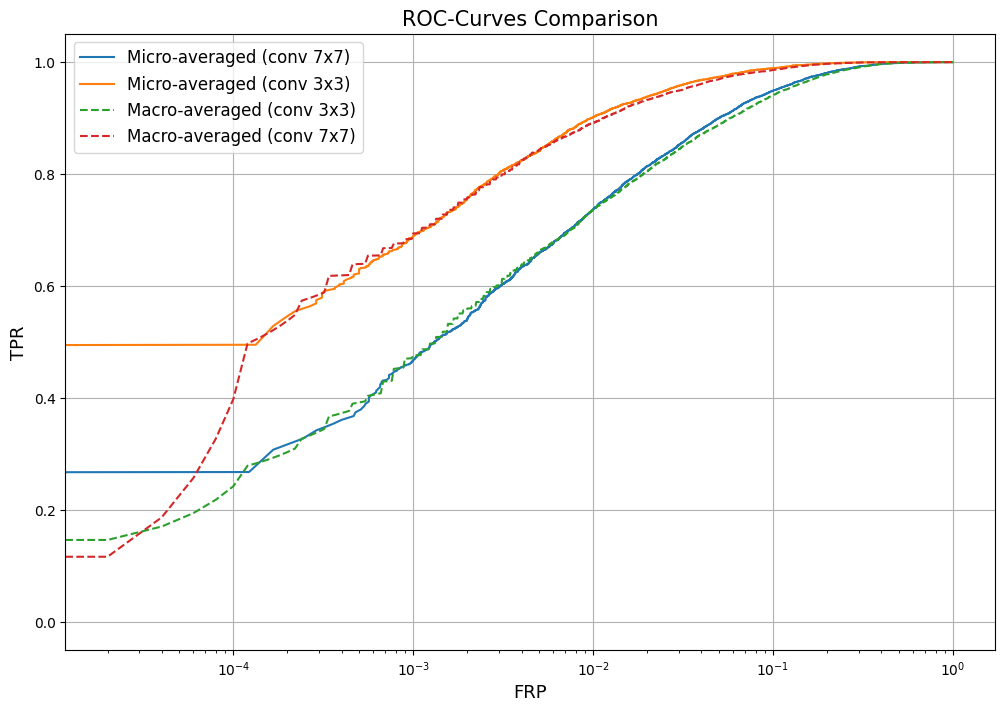

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))

axs.plot(
    *micro_averaged_roc_curve(y_true7x7, y_pred7x7),
    label="Micro-averaged (conv 7x7)",
    color="#1f77b4"
)

axs.plot(
    *micro_averaged_roc_curve(y_true3x3, y_pred3x3),
    label="Micro-averaged (conv 3x3)",
    color="#ff7f0e"
)

axs.plot(
    *macro_averaged_roc_curve(y_true7x7, y_pred7x7),
    label="Macro-averaged (conv 3x3)",
    color="#2ca02c",
    linestyle="--"
)

axs.plot(
    *macro_averaged_roc_curve(y_true3x3, y_pred3x3),
    label="Macro-averaged (conv 7x7)",
    color="#d62728",
    linestyle="--"
)

axs.set_xlabel("FRP", fontsize=13)
axs.set_ylabel("TPR", fontsize=13)
axs.set_xscale("log")
axs.set_title("ROC-Curves Comparison", fontsize=15)
axs.legend(loc="upper left", fontsize=12)
axs.grid()
plt.show()

### Объяснение полученных результатов 

Модель с конфигурацией первого слоя со свёрткой 3 на 3 и без операции MaxPooling показывает результат значительно лучше модели со свёрткой 7 на 7 и операцией MaxPooling.

Это связано с тем, что свёртка размера 7 на 7 (с последующим примененим MaxPooling) на изображениях с разрешением 32 на 32 не позволяет выделить столько же деталей, сколько свёртка 3 на 3.
Для изображений малого разрешения (32 на 32) свёртка 7 на 7 обладает избыточной аггрегирующей (обобщающей) способностью.


Выходное разрешение карт признаков изображений после первого слоя моделей с разными конфигурациями: 
- Conv 7x7 (stride=2) + MaxPool (stride=2): $N × 3 × 32 × 32 \rightarrow N × 64 × 8 × 8$

- Conv 3x3: $N × 3 × 32 × 32  \rightarrow N × 64 × 32 × 32$ 

(-0.5, 31.5, 31.5, -0.5)

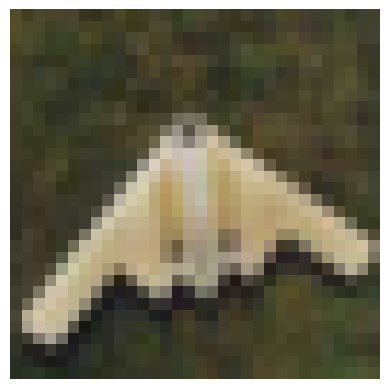

In [19]:
test_image = testset[52][0][None, :, :, :].to(device)

plt.imshow(test_image.cpu().reshape(3, 32, 32).permute(1, 2, 0))
plt.axis('off')

#### Карты признаков для тестового изображения в случае разных конфигураций сетей 

Для каждого из 64 каналов, получаемых после первого свёрточного слоя

In [20]:
net = None
clear_cache()

net = ResNet18(conv_size=7).to(device)
net.load_state_dict(torch.load("./checkpoint/model7x7_best.pt"))
print(net.conv1(test_image).shape) 

torch.Size([1, 64, 8, 8])


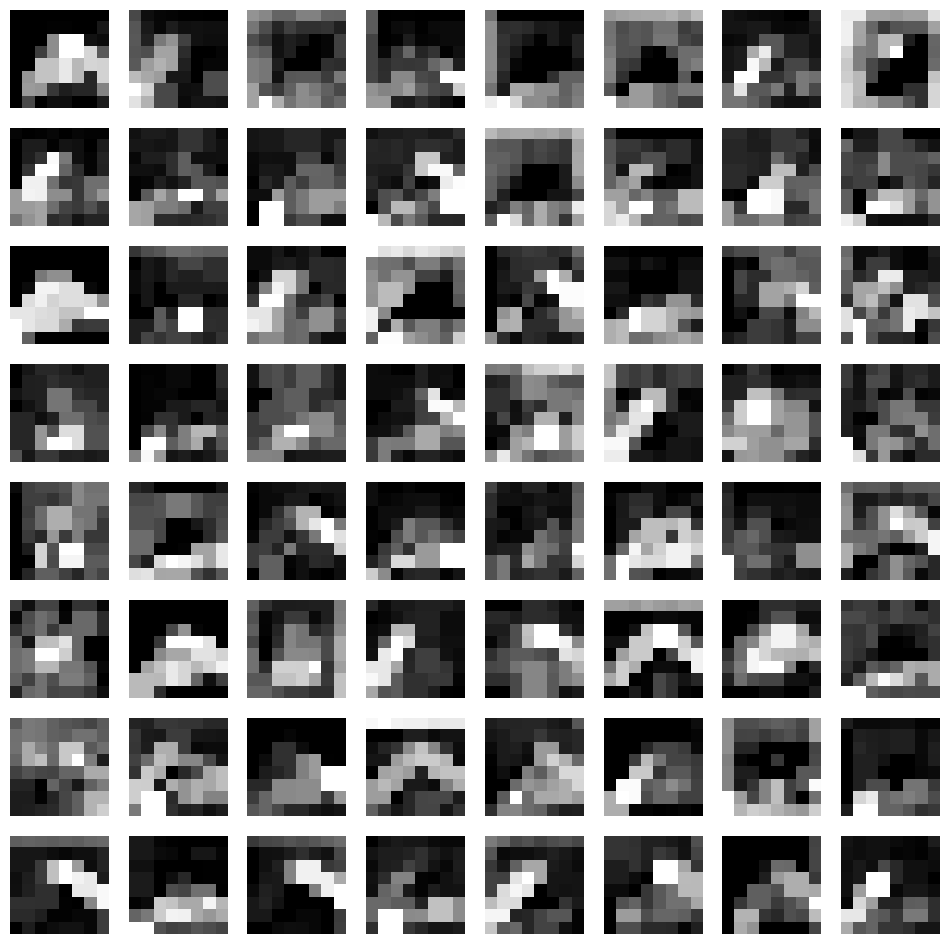

In [21]:
feature_map7x7 = net.conv1(test_image)[0]

fig, axs = plt.subplots(8, 8, figsize=(12, 12))
for i, map_ in enumerate(feature_map7x7):
    ax = axs[i // 8, i % 8]
    ax.imshow(map_.cpu()[:, :].detach(), cmap='gray')
    ax.axis('off')
plt.show()

In [22]:
net = None
clear_cache()

net = ResNet18(conv_size=3).to(device)
net.load_state_dict(torch.load("./checkpoint/model3x3_best.pt"))
print(net.conv1(test_image).shape) 

torch.Size([1, 64, 32, 32])


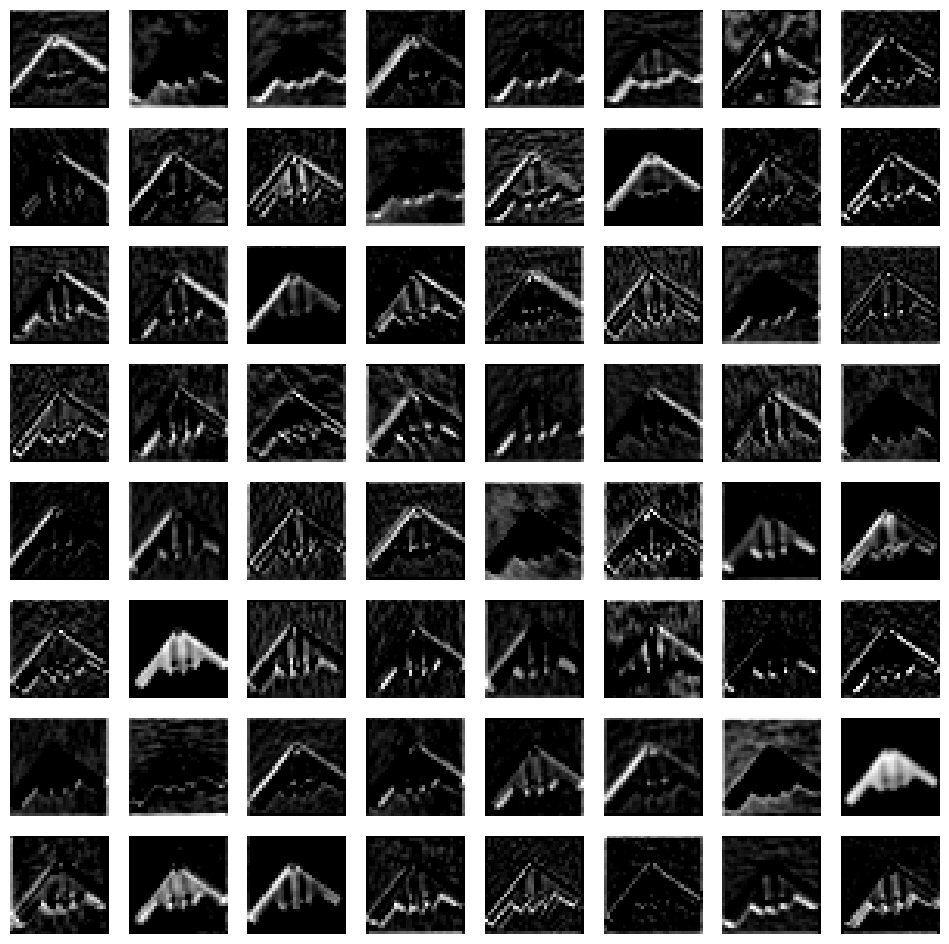

In [23]:
feature_map3x3 = net.conv1(test_image)[0]

fig, axs = plt.subplots(8, 8, figsize=(12, 12))
for i, map_ in enumerate(feature_map3x3):
    ax = axs[i // 8, i % 8]
    ax.imshow(map_.cpu()[:, :].detach(), cmap='gray')
    ax.axis('off')
plt.show()

In [24]:
!nvidia-smi

Mon Dec  4 11:58:37 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.58                 Driver Version: 537.58       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2070 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| 52%   31C    P8              10W / 215W |    887MiB /  8192MiB |     19%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--